# This is a text classification project for IU Course DLBAIPNLP01 – Project: NLP

### In this project we will use the 20 newsgroups text dataset to create a multi-label classifier.

In [30]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import os
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    f1_score,
    recall_score,
    RocCurveDisplay,
    roc_auc_score
)
from gensim.models import Word2Vec
import gensim
import pickle

In [8]:
nltk.download('stopwords', download_dir='/usr/nltk_data')
nltk.download('punkt_tab', download_dir='/usr/nltk_data')
nltk.download('punkt', download_dir='/usr/nltk_data')

[nltk_data] Downloading package stopwords to /usr/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /usr/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /usr/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
from sklearn.datasets import fetch_20newsgroups
import os
train_data_dir = os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","data","train")
test_data_dir = os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","data","test")
#ng_train_data, ng_train_target_data = fetch_20newsgroups(data_home=train_data_dir, subset="train",return_X_y=True )
#ng_test_data, ng_test_target_data = fetch_20newsgroups(data_home=test_data_dir, subset="test", return_X_y=True)
#print(type(ng_train_data),type(ng_train_target_data))

In [ ]:
print(f" Training data count Data = {len(ng_train_data)}, Classes = {len(ng_train_target_data)}")

 Training data count Data = 11314, Classes = 11314


In [ ]:
for i in range(10):
    print(f"{ng_train_data[i]} ### {ng_train_target_data[i]}")

In [10]:
training_data = fetch_20newsgroups(data_home=train_data_dir, subset="train")
training_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
print(set(training_data["target"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [11]:
# Creating a mapping of labels this will be used for providing the correct label at the time of prediction
label_mapping = {}
for i in range(len(training_data["target_names"])):
    label_mapping[i] = training_data["target_names"][i]
#print(label_mapping)

In [12]:
training_data_df = pd.DataFrame({"news_articles":training_data['data'], "label_id":training_data['target']})

In [ ]:
training_data_df.head(2)

,news_articles,label_id
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4


In [18]:
# Test Training split
test_df = training_data_df.groupby('label_id').head(20)
training_df = training_data_df.groupby('label_id').tail(545)

In [ ]:
test_df.head(2)

,news_articles,label_id
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4


In [ ]:
training_df.head(2)

,news_articles,label_id
11,From: david@terminus.ericsson.se (David Bold)\...,19
15,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0


In [13]:
# function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

In [14]:
# function to set stem words
def stem_words(text):
    ps = PorterStemmer()
    words = word_tokenize(text)
    stemmed_words_list = []
    for word in words:
        stemmed_words_list.append(ps.stem(word))
    return " ".join(stemmed_words_list)
    #print(w, " : ", ps.stem(w))
#print(stem_words("Programming programmers to learing python"))

In [15]:
# Clean the text
email_pattern = re.compile(r"\S*@\S*\s?")
special_characters = re.compile(r"[^A-Za-z0-9]+")
remove_no_of_lines = re.compile(r"[Lines]+:\s\d\d$")
def clean_text(text,token_length=None):
    text = text.lower()
    text = email_pattern.sub("",text)
    #text = re.sub(r"[Lines]+:\s\d\d$","",text)
    #text = remove_no_of_lines.sub("",text)
    text = text.replace("From:", "").replace("Subject:","").replace("Nntp-Posting-Host:","").replace("Organization:","")
    text = text.replace("\n", " ")
    text = special_characters.sub(" ",text)
    text = remove_stop_words(text)
    text = stem_words(text)
    word_tokens = word_tokenize(text)
    selected_tokens = word_tokens[:token_length]
    return " ".join(selected_tokens)

In [11]:
# Function to create word vectors using bag of words
# https://pemagrg.medium.com/saving-sklearn-model-to-pickle-595da291ec1c

def create_bow_model(vocab):
    word_vector = CountVectorizer()
    word_vector_model = word_vector.fit(vocab)
    pickle.dump(word_vector_model, open(os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","model","word_vector_model.pickle"),"wb"))
    return os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","model","word_vector_model.pickle")

class Generate_Bow_Vector:
    def __init__(self,model_path):
        self.word_vector_model = pickle.load(open(model_path,"rb"))
    def create_bow_vectors(self, text):
        # Loaded bow model from local
        #word_vector_model = pickle.load(open(os.path.join(os.getcwd(),"model","word_vector_model.pickle")))
        return self.word_vector_model.transform([text])

In [16]:
# Creating TFIDF embeding with token vector size of 703
def create_tfidf_model(vocab, max_features=703):
  td = TfidfVectorizer(max_features = max_features)
  tfidfembeding = td.fit(vocab)
  pickle.dump(tfidfembeding, open(os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","models","tfidf_model.pickle"),"wb"))
  return os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","models","tfidf_model.pickle")

class Generate_Tfidf_Vector():
  def __init__(self,model_path) -> None:
    self.model = pickle.load(open(model_path,"rb"))
  def create_tfidf_vectors(self, text):
    result = self.model.transform([text])
    return result[0]


In [19]:
# Batch1
# Create Vocab to train tfidf model after cleaning the text
clean_vocab = [clean_text(x) for x in training_data_df["news_articles"]]
tfidf_model_path = create_tfidf_model(clean_vocab)
# Create Training and test data with clean data
generate_tfidf_model_instance = Generate_Tfidf_Vector(tfidf_model_path)
X_train_clean = [clean_text(x) for x in training_df["news_articles"]]
X_test_clean = [clean_text(x) for x in test_df["news_articles"]]
X_train_tfidf_sparce_vectors = [generate_tfidf_model_instance.create_tfidf_vectors(text) for text in X_train_clean ]
X_test_tfidf_sparce_vectors = [generate_tfidf_model_instance.create_tfidf_vectors(text) for text in X_test_clean]
X_train_vector_list = [ x.toarray()[0].tolist() for x in X_train_tfidf_sparce_vectors ]
X_test_vector_list = [ x.toarray()[0].tolist() for x in X_test_tfidf_sparce_vectors ]
y_train = training_df["label_id"]
y_test = test_df["label_id"]
print( len(X_train_vector_list), len(y_train), len(X_test_vector_list), len(y_test))

10587 10587 400 400


In [ ]:
print( len(X_train_vector_list), len(y_train), len(X_test_vector_list), len(y_test))

10587 10587 400 400


In [ ]:
print(type(X_train_vector_list), len(X_train_vector_list), X_train_vector_list[:1])

<class 'list'> 10587 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08339689867491362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03363652315784946, 0.0, 0.0, 0.046948334683519236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0426993460091913, 0.0, 0.0, 0.0, 0.03538153371602383, 0.0, 0.039148932863931105, 0.0, 0.0, 0.04393592485551172, 0.0, 0.03609735683786343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03576484254700848, 0.0, 0.0, 0.0, 0.0, 0.09299021358845011, 0.0, 0.0, 0.04585169973492279, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03127512994747288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08950422010286867, 0.0, 0.14167382085776126, 0.07663455084331487, 0.0, 0.0, 0.0, 0.04308722515174204, 

In [23]:
# Training and getting the predection results
gnb_model = model_train(X_train_vector_list, y_train,"gnb_model_run1")

run1_prediction = model_predict("gnb_model_run1",X_test_vector_list)

In [ ]:
len(run1_prediction)

400

In [24]:
# Batch 1 Printing metrics
print(f"Mertics for Run 1 are:\nAccuracy is :{ accuracy(y_test,run1_prediction)} \nMicro Average Precision is :{average_precision(y_test,run1_prediction)} \nMicro Average Recall is :{average_recall(y_test,run1_prediction)} \nMicro Average F1 Score is :{average_f1_score(y_test,run1_prediction)}")

Mertics for Run 1 are:
Accuracy is :0.65 
Micro Average Precision is :0.65 
Micro Average Recall is :0.65 
Micro Average F1 Score is :0.65


In [25]:
print(f"Micro ROC Area under the curve for each class is:\n {per_class_roc(y_test,run1_prediction)}")

Micro ROC Area under the curve for each class is:
 {0: 0.8671052631578947, 1: 0.7473684210526317, 2: 0.7184210526315788, 3: 0.7736842105263158, 4: 0.7868421052631578, 5: 0.7894736842105263, 6: 0.7947368421052632, 7: 0.8407894736842105, 8: 0.8473684210526315, 9: 0.7842105263157895, 10: 0.8355263157894737, 11: 0.8986842105263159, 12: 0.6894736842105262, 13: 0.8486842105263157, 14: 0.9223684210526316, 15: 0.8644736842105264, 16: 0.8460526315789473, 17: 0.975, 18: 0.7881578947368422, 19: 0.6973684210526315}


In [26]:
# Batch 1 Printing metrics
print(f"Mertics for Run 1 are:\nAccuracy is :{ accuracy(y_test,run1_prediction)} \nMacro Average Precision is :{average_precision(y_test,run1_prediction,'macro')} \nMacro Average Recall is :{average_recall(y_test,run1_prediction,'macro')} \nMacro Average F1 Score is :{average_f1_score(y_test,run1_prediction,'macro')}")

Mertics for Run 1 are:
Accuracy is :0.65 
Macro Average Precision is :0.6997564271131794 
Macro Average Recall is :0.6499999999999999 
Macro Average F1 Score is :0.6607346201385796


In [27]:
print(f"Macro ROC Area under the curve for each class is:\n {per_class_roc(y_test,run1_prediction,'macro')}")

Macro ROC Area under the curve for each class is:
 {0: 0.8671052631578947, 1: 0.7473684210526317, 2: 0.7184210526315788, 3: 0.7736842105263158, 4: 0.7868421052631578, 5: 0.7894736842105263, 6: 0.7947368421052632, 7: 0.8407894736842105, 8: 0.8473684210526315, 9: 0.7842105263157895, 10: 0.8355263157894737, 11: 0.8986842105263159, 12: 0.6894736842105262, 13: 0.8486842105263157, 14: 0.9223684210526316, 15: 0.8644736842105264, 16: 0.8460526315789473, 17: 0.975, 18: 0.7881578947368422, 19: 0.6973684210526315}


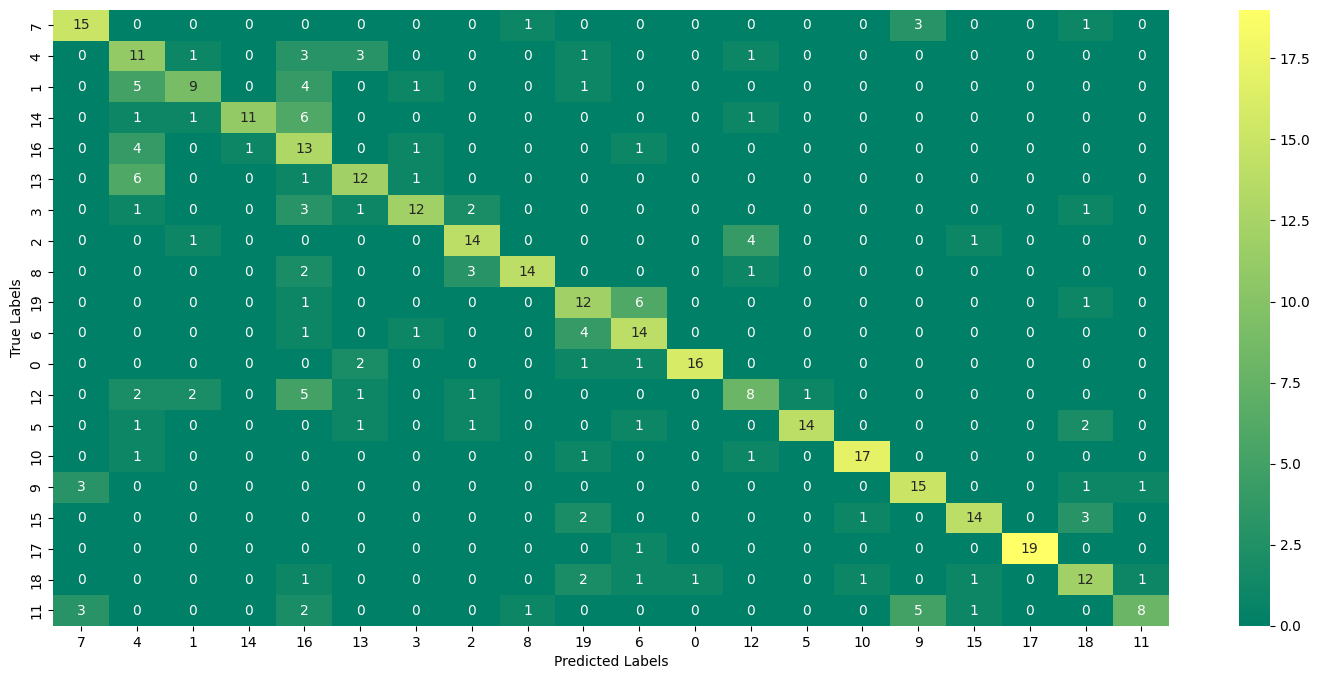

In [29]:
# Generate heat map for the Batch 1 prediction
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, run1_prediction), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [32]:
# Run2 with Decision Tree Algorithim
dt_model = model_train(X_train_vector_list, y_train,"DT_model_run1",model_type="DecisionTree")

run1_prediction = model_predict(dt_model,X_test_vector_list)

In [33]:
# Batch 1 Printing metrics Run2
print(f"Mertics for Run 2 are:\nAccuracy is :{ accuracy(y_test,run1_prediction)} \nMicro Average Precision is :{average_precision(y_test,run1_prediction)} \nMicro Average Recall is :{average_recall(y_test,run1_prediction)} \nMicro Average F1 Score is :{average_f1_score(y_test,run1_prediction)}")

Mertics for Run 2 are:
Accuracy is :0.67 
Micro Average Precision is :0.67 
Micro Average Recall is :0.67 
Micro Average F1 Score is :0.67


In [34]:
print(f"Micro ROC Area under the curve for each class is:\n {per_class_roc(y_test,run1_prediction)}")

Micro ROC Area under the curve for each class is:
 {0: 0.9986842105263157, 1: 0.8105263157894737, 2: 0.8184210526315789, 3: 0.6368421052631579, 4: 0.6842105263157894, 5: 0.8157894736842105, 6: 0.7447368421052631, 7: 0.7934210526315789, 8: 0.9421052631578947, 9: 0.7092105263157894, 10: 0.7631578947368421, 11: 0.8960526315789474, 12: 0.6605263157894737, 13: 0.7657894736842106, 14: 0.7921052631578948, 15: 0.8197368421052631, 16: 0.9947368421052631, 17: 0.8973684210526316, 18: 0.9960526315789473, 19: 0.986842105263158}


In [35]:
# Batch 1 Printing metrics Run2
print(f"Mertics for Run 1 are:\nAccuracy is :{ accuracy(y_test,run1_prediction)} \nMacro Average Precision is :{average_precision(y_test,run1_prediction,'macro')} \nMacro Average Recall is :{average_recall(y_test,run1_prediction,'macro')} \nMacro Average F1 Score is :{average_f1_score(y_test,run1_prediction,'macro')}")

Mertics for Run 1 are:
Accuracy is :0.67 
Macro Average Precision is :0.6660970627762929 
Macro Average Recall is :0.6700000000000002 
Macro Average F1 Score is :0.6630872239936353


In [36]:
print(f"Macro ROC Area under the curve for each class is:\n {per_class_roc(y_test,run1_prediction,'macro')}")

Macro ROC Area under the curve for each class is:
 {0: 0.9986842105263157, 1: 0.8105263157894737, 2: 0.8184210526315789, 3: 0.6368421052631579, 4: 0.6842105263157894, 5: 0.8157894736842105, 6: 0.7447368421052631, 7: 0.7934210526315789, 8: 0.9421052631578947, 9: 0.7092105263157894, 10: 0.7631578947368421, 11: 0.8960526315789474, 12: 0.6605263157894737, 13: 0.7657894736842106, 14: 0.7921052631578948, 15: 0.8197368421052631, 16: 0.9947368421052631, 17: 0.8973684210526316, 18: 0.9960526315789473, 19: 0.986842105263158}


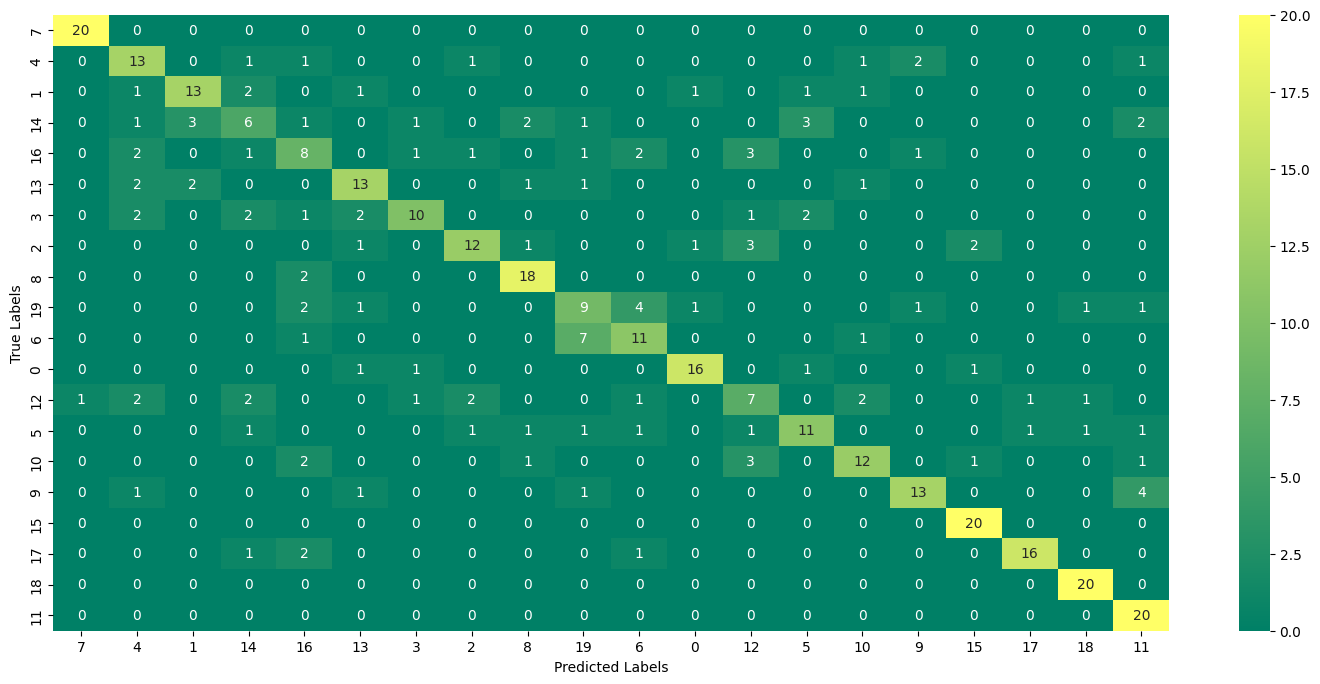

In [37]:
# Generate heat map for the Batch 1 prediction Run2
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, run1_prediction), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
# Batch2 Increasing the vector size to 1400
# Create Vocab to train tfidf model after cleaning the text
clean_vocab = [clean_text(x) for x in training_data_df["news_articles"]]
tfidf_model_path = create_tfidf_model(clean_vocab,max_features=1400)
# Create Training and test data with clean data
generate_tfidf_model_instance = Generate_Tfidf_Vector(tfidf_model_path)
X_train_clean = [clean_text(x) for x in training_df["news_articles"]]
X_test_clean = [clean_text(x) for x in test_df["news_articles"]]
X_train_tfidf_sparce_vectors = [generate_tfidf_model_instance.create_tfidf_vectors(text) for text in X_train_clean ]
X_test_tfidf_sparce_vectors = [generate_tfidf_model_instance.create_tfidf_vectors(text) for text in X_test_clean]
X_train_vector_list = [ x.toarray()[0].tolist() for x in X_train_tfidf_sparce_vectors ]
X_test_vector_list = [ x.toarray()[0].tolist() for x in X_test_tfidf_sparce_vectors ]
y_train = training_df["label_id"]
y_test = test_df["label_id"]
print( len(X_train_vector_list), len(y_train), len(X_test_vector_list), len(y_test))

10587 10587 400 400


In [39]:
# Run2 with Decision Tree Algorithim
gb_b2_model = model_train(X_train_vector_list, y_train,"GB_model_run2",model_type="GausianNaiveBays")
dt_b2_model = model_train(X_train_vector_list, y_train,"DT_model_run2",model_type="DecisionTree")

GB_model_run2_prediction = model_predict(gb_b2_model,X_test_vector_list)
DT_model_run2_prediction = model_predict(dt_b2_model,X_test_vector_list)


In [40]:
# Batch 2 Printing metrics Run1
print(f"Mertics for Run 2 are:\nAccuracy is :{ accuracy(y_test,GB_model_run2_prediction)} \nMicro Average Precision is :{average_precision(y_test,GB_model_run2_prediction)} \nMicro Average Recall is :{average_recall(y_test,GB_model_run2_prediction)} \nMicro Average F1 Score is :{average_f1_score(y_test,GB_model_run2_prediction)}")

Mertics for Run 2 are:
Accuracy is :0.735 
Micro Average Precision is :0.735 
Micro Average Recall is :0.735 
Micro Average F1 Score is :0.735


In [41]:
# Batch 2 Printing metrics Run1
print(f"Mertics for Run 1 are:\nAccuracy is :{ accuracy(y_test,GB_model_run2_prediction)} \nMacro Average Precision is :{average_precision(y_test,GB_model_run2_prediction,'macro')} \nMacro Average Recall is :{average_recall(y_test,GB_model_run2_prediction,'macro')} \nMacro Average F1 Score is :{average_f1_score(y_test,GB_model_run2_prediction,'macro')}")

Mertics for Run 1 are:
Accuracy is :0.735 
Macro Average Precision is :0.7501467454824232 
Macro Average Recall is :0.735 
Macro Average F1 Score is :0.7342040073304565


In [42]:
print(f"Micro ROC Area under the curve for each class is:\n {per_class_roc(y_test,GB_model_run2_prediction)}")

Micro ROC Area under the curve for each class is:
 {0: 0.9921052631578947, 1: 0.7131578947368421, 2: 0.8144736842105262, 3: 0.7842105263157895, 4: 0.7789473684210527, 5: 0.8631578947368421, 6: 0.6973684210526315, 7: 0.8921052631578946, 8: 0.8973684210526316, 9: 0.8381578947368421, 10: 0.8934210526315789, 11: 0.9236842105263159, 12: 0.6921052631578947, 13: 0.95, 14: 0.9460526315789473, 15: 0.8486842105263157, 16: 0.9736842105263157, 17: 0.9236842105263159, 18: 0.9421052631578947, 19: 0.8460526315789473}


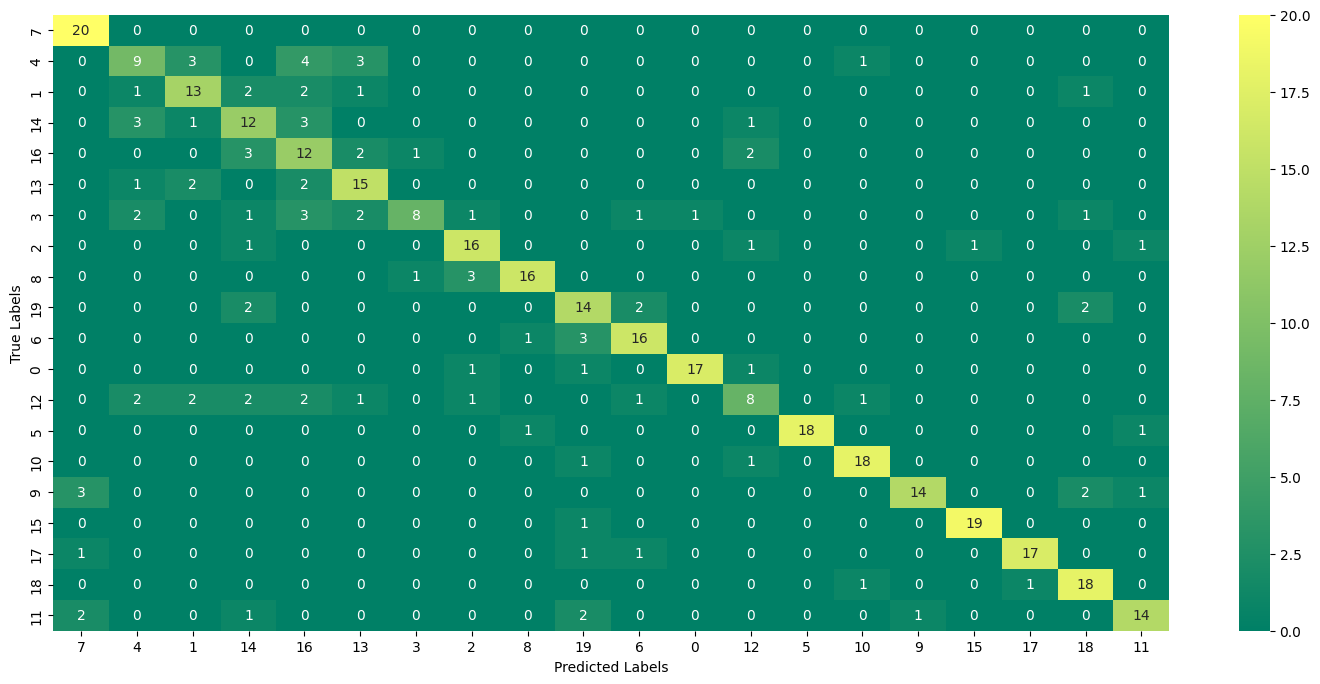

In [43]:
# Generate heat map for the Batch 2 prediction Run1
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, GB_model_run2_prediction), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [44]:
# Batch 2 Printing metrics Run1
print(f"Mertics for Run 2 are:\nAccuracy is :{ accuracy(y_test,DT_model_run2_prediction)} \nMicro Average Precision is :{average_precision(y_test,DT_model_run2_prediction)} \nMicro Average Recall is :{average_recall(y_test,DT_model_run2_prediction)} \nMicro Average F1 Score is :{average_f1_score(y_test,DT_model_run2_prediction)}")

Mertics for Run 2 are:
Accuracy is :0.675 
Micro Average Precision is :0.675 
Micro Average Recall is :0.675 
Micro Average F1 Score is :0.675


In [45]:
# Batch 2 Printing metrics Run1
print(f"Mertics for Run 1 are:\nAccuracy is :{ accuracy(y_test,DT_model_run2_prediction)} \nMacro Average Precision is :{average_precision(y_test,DT_model_run2_prediction,'macro')} \nMacro Average Recall is :{average_recall(y_test,DT_model_run2_prediction,'macro')} \nMacro Average F1 Score is :{average_f1_score(y_test,DT_model_run2_prediction,'macro')}")

Mertics for Run 1 are:
Accuracy is :0.675 
Macro Average Precision is :0.6765356102710773 
Macro Average Recall is :0.675 
Macro Average F1 Score is :0.6650859825937823


In [46]:
print(f"Micro ROC Area under the curve for each class is:\n {per_class_roc(y_test,DT_model_run2_prediction)}")

Micro ROC Area under the curve for each class is:
 {0: 0.9947368421052631, 1: 0.7342105263157895, 2: 0.8328947368421052, 3: 0.6644736842105263, 4: 0.643421052631579, 5: 0.7855263157894737, 6: 0.7394736842105264, 7: 0.8210526315789474, 8: 0.9460526315789473, 9: 0.7460526315789474, 10: 0.8934210526315789, 11: 0.9197368421052632, 12: 0.6842105263157894, 13: 0.7644736842105264, 14: 0.7421052631578947, 15: 0.7986842105263159, 16: 0.9960526315789473, 17: 0.8960526315789474, 18: 0.9855263157894737, 19: 0.9907894736842106}


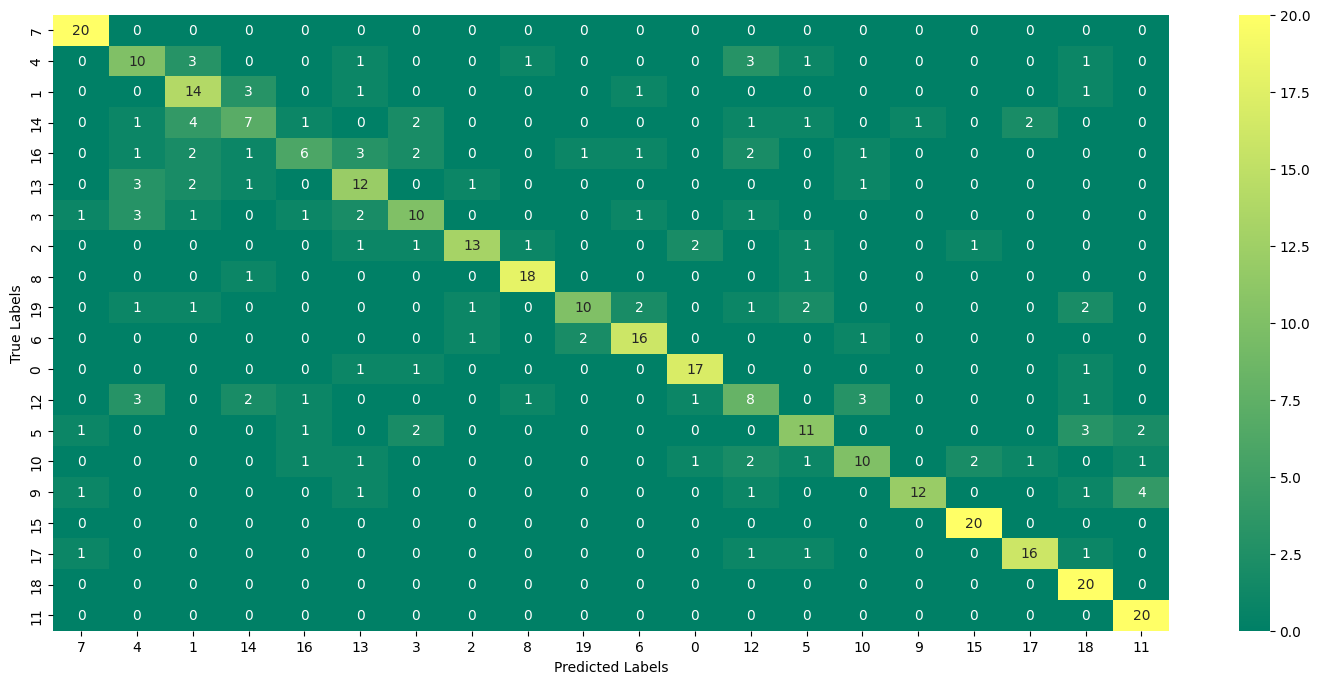

In [47]:
# Generate heat map for the Batch 2 prediction Run1
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, DT_model_run2_prediction), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Creating data processing pipeline for cleaning and creating embedings
def create_embedings(type,data,vector_model_path):
    embedings = []
    # Create model for bow
    #model_path = create_bow_model(data)
    bow_vector_instance = Generate_Bow_Vector(vector_model_path)
    for text in data:
#        processed_text = clean_text(text)
        if type == "bow":
            bow_embdeing = bow_vector_instance.create_bow_vectors(text)
            embedings.append(bow_embdeing)
    return embedings

In [ ]:
word_vector_model_path = create_bow_model(clean_vocab)

In [ ]:
training_df.head(1)

,news_articles,label_id
11,From: david@terminus.ericsson.se (David Bold)\...,19


In [ ]:
len(training_df["news_articles"]), len(training_df["label_id"]), len(test_df["news_articles"]),len(test_df["label_id"])

(10587, 10587, 400, 400)

In [ ]:
training_embedings = create_embedings(type="bow", data=training_df["news_articles"],vector_model_path=word_vector_model_path)
test_embedings = create_embedings(type="bow", data=test_df["news_articles"],vector_model_path=word_vector_model_path)

In [ ]:
len(test_embedings)

400

In [ ]:
len(training_embedings)

10587

In [ ]:
def convert_dense_array_to_list(dense_array):
    normal_array = []
    for list_item in dense_array:
        normal_array.append(list_item.toarray()[0].tolist())
    return normal_array
#training_embedings

In [31]:
# Naive Baise Implementation

def model_train(X_train,y_train, model_name, model_type="GausianNaiveBays",**kwargs):
    match model_type:
        case "GausianNaiveBays":
            gnb = GaussianNB()
            model = gnb.fit(X_train, y_train)
            pickle.dump(model, open(os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","models",model_name),"wb"))
            return model_name
        case "DecisionTree":
          dtree = tree.DecisionTreeClassifier()
          model = dtree.fit(X_train,y_train)
          pickle.dump(model, open(os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","models",model_name),"wb" ))
          return model_name

def model_predict(model_name, X_test):
    model = pickle.load(open(os.path.join(os.getcwd(),"drive","MyDrive","nlp_project","models",model_name),"rb"))
    return model.predict(X_test)

            #.predict(X_test)
#print("Number of mislabeled points out of a total %d points : %d"
#      % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
# Metric implementation
# https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification

In [3]:
# functions to return metrics
def accuracy(actual, predicted):
    return accuracy_score(actual, predicted)

def average_precision(actual, predicted, average_type="micro"):
    '''
    average_type: takes two values "micro" which is the default if not passed or
    "macro" which needs to be passed explicltely
    '''
    return precision_score(actual, predicted, average=average_type)

def average_recall(actual, predicted, average_type="micro"):
    '''
    average_type: takes two values "micro" which is the default if not passed or
    "micro" which need to be passed explicltely
    '''
    return recall_score(actual, predicted, average=average_type)

def average_f1_score(actual, predicted, average_type="micro"):
    '''
    average_type: takes two values "micro" which is the default if not passed or
    "micro" which need to be passed explicltely
    '''
    return f1_score(actual, predicted, average=average_type)

def per_class_roc(actual, predicted, average_type="micro"):
    distinc_classes = set(actual)
    result = {}
    for classes in distinc_classes:

        #creating a list of all the classes except the current class
        other_class = [x for x in distinc_classes if x != classes]

        #marking the current class as 1 and all other classes as 0
        actual_class = [0 if x in other_class else 1 for x in actual]
        pred_class = [0 if x in other_class else 1 for x in predicted]

        #using the sklearn metrics method to calculate the roc_auc_score
        score = roc_auc_score(actual_class, pred_class, average = average_type)
        result[classes] = score
    return result


In [ ]:
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#Prepare data for training and prediction
X_train = convert_dense_array_to_list(training_embedings)
X_test = convert_dense_array_to_list(test_embedings)
y_train = training_df["label_id"].tolist()
y_test = test_df["label_id"].tolist()
len(X_train),len(X_test),len(y_train),len(y_test)

(10587, 400, 10587, 400)

In [ ]:
len(X_train[0])

59627

In [ ]:
gnb = model_train(X_train,y_train,model_name="GausianNaiveBays")
print(gnb)

In [ ]:
l = [1,2,3,4,5,6]
l[:None]

[1, 2, 3, 4, 5, 6]

In [ ]:
!pwd

/content


In [ ]:
len(clean_vocab)

11314

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 703)
tfidfembeding = td.fit(clean_vocab)

In [ ]:
clean_vocab[0]

'thing subject car nntp post host rac3 wam umd edu organ univers maryland colleg park line 15 wonder anyon could enlighten car saw day 2 door sport car look late 60 earli 70 call bricklin door realli small addit front bumper separ rest bodi know anyon tellm model name engin spec year product car made histori whatev info funki look car pleas e mail thank il brought neighborhood lerxst'

In [ ]:
x = tfidfembeding.transform([clean_vocab[200]])
x[0]

<1x703 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [ ]:
x[0].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.14530113, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.17417659, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06

In [52]:
! cd content/drive/MyDrive/Colab Notebooks/

/bin/bash: line 1: cd: too many arguments
